In [36]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [37]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/36h11/s_yaw_36h11_2m_360_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60]

In [38]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [39]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,21.553687
1,0.185261,-5.864441
2,0.244160,-4.353328
3,0.363009,-4.147632
4,0.484082,-1.581312
...,...,...
1202,73.034391,60.639841
1203,73.065075,61.633995
1204,73.098443,61.761572
1205,73.131788,61.069054


<AxesSubplot:xlabel='relative_time'>

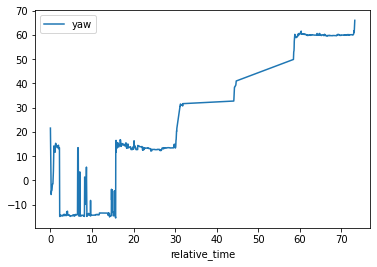

In [40]:
# initial graph
df.plot(x='relative_time', y=target)

In [41]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [42]:
# the amount of data points we are left with
len(x[peaks])

245

In [43]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

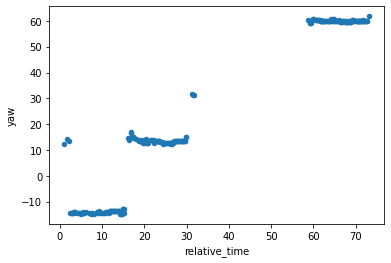

In [44]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [45]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
11,1.082728,12.400920,15
16,1.742006,14.247172,15
22,2.112221,13.545840,15
27,2.425561,-14.360875,0
31,2.676037,-14.545683,0
...,...,...,...
1178,72.230238,60.065976,60
1181,72.331065,60.146551,60
1189,72.600247,60.061569,60
1192,72.700746,60.136805,60


In [46]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [47]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [48]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
11,1.082728,12.400920,15,2.599080
16,1.742006,14.247172,15,0.752828
27,2.425561,-14.360875,0,14.360875
31,2.676037,-14.545683,0,14.545683
345,16.798396,16.778044,30,13.221956
347,16.865419,16.695570,30,13.304430
748,31.298264,31.496819,45,13.503181
756,31.564720,31.186819,45,13.813181
790,58.831516,60.245912,60,-0.245912
798,59.098905,59.174886,60,0.825114


In [49]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,61.0,14.051637,0.505496,12.963578,13.511449,14.229205,14.422466,14.815687
15,81.0,1.585849,0.681215,-0.158584,1.403883,1.610737,2.201709,2.850047
30,2.0,13.263193,0.058318,13.221956,13.242575,13.263193,13.283812,13.304430
45,3.0,13.638902,0.158556,13.503181,13.551762,13.600343,13.706762,13.813181
60,98.0,-0.007335,0.331959,-1.761572,-0.108408,0.005505,0.171740,0.928389


In [50]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

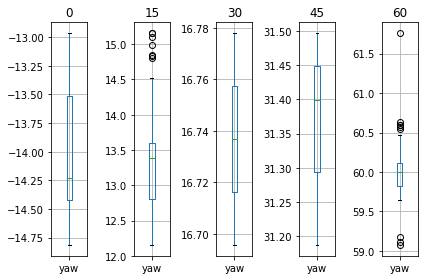

In [51]:
box_plotter(target)

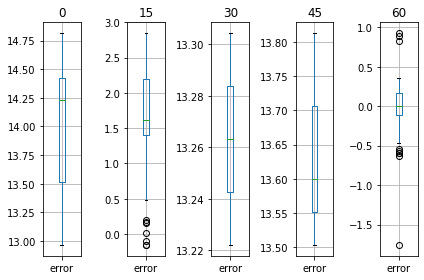

In [52]:
box_plotter('error')

In [53]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_filtered_by_targets)

,relative_time,yaw,true_yaw,error
11,1.082728,12.400920,15,2.599080
16,1.742006,14.247172,15,0.752828
22,2.112221,13.545840,15,1.454160
27,2.425561,-14.360875,0,14.360875
31,2.676037,-14.545683,0,14.545683
33,2.797729,-14.422466,0,14.422466
36,2.985746,-14.514716,0,14.514716
38,3.116131,-14.425851,0,14.425851
40,3.246219,-14.039526,0,14.039526
43,3.426411,-14.099798,0,14.099798
